In [7]:
import pandas as pd
import subprocess
import re
from __future__ import print_function
import numpy as np

In [8]:
file_bam = './SRP002284.sulfur.merged.bam'
df_gene_gff = pd.read_pickle('./tophat/df.cre.gff.gene.index.pickle')

file_gff = '/ref/Cre/genemodel_correction/Creinhardtii_281_v5.5.gene.gff3'
df_gff   = pd.read_csv(file_gff,sep='\t',skiprows=2,header=None)

df_gff['genename'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))
df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:4]))

# grep longest transcript names
mask        = (df_gff[2] == 'mRNA')
df_gff_mRNA = df_gff[mask]
df_gff_mRNA['longest'] = df_gff_mRNA[8].apply(lambda x : x.split(';')[3].replace('longest=',''))
df_gff_mRNA_index =  df_gff_mRNA.set_index('transcriptname')

def get_longest(x):
    try:
        return df_gff_mRNA_index.loc[x]['longest']
    except KeyError:
        return None
df_gff['longest'] = df_gff['transcriptname'].apply(get_longest)

df_gff_index = df_gff.set_index(['genename','longest'])

df_gff_index.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0             1               2      3  \
genename      longest                                                      
Cre01.g000017 NaN      chromosome_1  phytozomev10            gene  18766   
              1        chromosome_1  phytozomev10            mRNA  18766   
              1        chromosome_1  phytozomev10  five_prime_UTR  18766   
              1        chromosome_1  phytozomev10             CDS  19163   
              1        chromosome_1  phytozomev10             CDS  19329   

                           4  5  6  7  \
genename      longest                   
Cre01.g000017 NaN      20237  .  +  .   
              1        20237  .  +  .   
              1        19162  .  +  .   
              1        19178  .  +  0   
              1        19948  .  +  2   

                                                                       8  \
genename      longest                                                      
Cre01.g000017 NaN               ID=Cre01.g000017.v5.5;Name=Cre01.g000017   
              1        ID=Cre01.g000017.t1.1.v5.5;Name=Cre01.g000017....   
              1        ID=Cre01.g000017.t1.1.v5.5.five_prime_UTR.1;Pa...   
              1        ID=Cre01.g000017.t1.1.v5.5.CDS.1;Parent=Cre01....   
              1        ID=Cre01.g000017.t1.1.v5.5.CDS.2;Parent=Cre01....   

                           transcriptname  
genename      longest                      
Cre01.g000017 NaN      Cre01.g000017.v5.5  
              1        Cre01.g000017.t1.1  
              1        Cre01.g000017.t1.1  
              1        Cre01.g000017.t1.1  
              1        Cre01.g000017.t1.1

In [9]:
genename = 'Cre04.g217550'
chromosome, left, right = df_gene_gff.loc[genename][[0,3,4]]

print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)

samtools view ./SRP002284.sulfur.merged.bam chromosome_4:245151-257595 > temp.sam


0

In [10]:
df_sam = pd.read_csv('temp.sam',sep='\t',header=None)

df_sam['SRRID'] = df_sam[0].apply(lambda x:x.split('.')[0])
df_sam['READID'] = df_sam[0].apply(lambda x:x.split('.')[1])
df_sam['PAIRID'] = df_sam[0].apply(lambda x:x.split('.')[2])

mask = (df_sam[8] > 0)
df_sam_forward = df_sam[mask]
df_sam_forward = df_sam_forward.sort(3)
READID_LIST = df_sam_forward['READID']

df_sam_index = df_sam.set_index(['SRRID','READID','PAIRID'])
df_sam_index = df_sam_index.sort([3])

def cigar_parse(cigar):
    match = re.findall(r'(\d+)(\w)', cigar)
    return match

Exception pandas.parser.CParserError: CParserError('Error tokenizing data. C error: Expected 20 fields in line 2044, saw 21\n',) in 'pandas.parser.TextReader._tokenize_rows' ignored


IndexError: list index out of range

In [320]:
# SVG
rect = '<rect x="%d" y="%d" width="%d" height="%d" style="fill:%s;stroke:%s;stroke-width:1;fill-opacity:0.8;stroke-opacity:0.3" />'
line = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />'

In [323]:
Outfile = open('test.svg','w')

each_height = 5
each_space  = 2
box_height  = 3
bridge_height = 2

total_canvas_rows = 100 + 2 # 2 for gene model

canvas_width = 1000
canvas_height = total_canvas_rows*(each_height+each_space)

real_width = right-left+1+100+100

print('''<svg height="%d" width="%d">'''%(canvas_height,canvas_width),file=Outfile)
gene_space = np.zeros([total_canvas_rows,real_width]) # 100 for paired end stretching out of border

############################################################################ drawing space set
def get_ratio(x):
    return int(float(x)/float(real_width) * canvas_width)


df = df_gff_index.loc[(genename,'1')]
df = df.reset_index()
df = df.sort(3)
  
fill_CDS   = 'yellow'
strock_CDS = 'black'

fill_UTR   = 'blue'
strock_UTR = 'black'

for i in df.index:
    if df.loc[i][2] == 'mRNA':
        x1 = get_ratio(df.loc[i][3] - left + 100)
        y1 = int(each_height/2) + 1
        x2 = get_ratio(df.loc[i][4] - left + 100)
        y2 = int(each_height/2)
        print(line%(x1,y1,x2,y2,'black'),file=Outfile)
    elif 'UTR' in df.loc[i][2]:
        x1 = get_ratio(df.loc[i][3] - left + 100)
        y1 = 0 + 1 
        w  = get_ratio(df.loc[i][4] - df.loc[i][3])
        h  = each_height
        print(rect%(x1,y1,w,h,fill_UTR,strock_UTR),file=Outfile)
    elif 'CDS' in df.loc[i][2]:
        x1 = get_ratio(df.loc[i][3] - left + 100)
        y1 = 0 + 1
        w  = get_ratio(df.loc[i][4] - df.loc[i][3])
        h  = each_height
        print(rect%(x1,y1,w,h,fill_CDS,strock_CDS),file=Outfile)

########################################################################## gene model drawing


SRRID_list = set(df_sam_index.index.get_level_values('SRRID'))
readnumber = 0
bPass = 1
for SRRID in SRRID_list:
    READID_list = df_sam_index.loc[SRRID].index.get_level_values('READID')
    for READID in READID_list:
          
        df = df_sam_index.loc[(SRRID,READID)]
        if len(df) == 2:
            pass
        else: continue
        ##################################### cigar check start
        gap_length = 0
        for cigar in df[5]:
            cigarM       = cigar_parse(cigar)
            #print(cigarM)
            cigarstrings = [x[1] for x in cigarM]
            cigarvalues  = [x[0] for x in cigarM]
            for i, cigarstring in enumerate(cigarstrings):
                if cigarstring == 'N' or cigarstring == 'I':
                    gap_length += int(cigarvalues[i])
                    
            
        fragstart      = min(df[3])-left+100
        fragmentsize   = max(df[8])
        fragmentsize_r = min(df[8])
        insertsize     = fragmentsize - gap_length - 200
        
        if insertsize < 10:
            continue
        if fragmentsize_r > 0 :
            continue
        ##################################################################### Error remove
        srow = None
        for nrow, row in enumerate(gene_space):
            if nrow <= 2:
                continue
            if max(row[fragstart:fragstart+fragmentsize]) > 0 :
                continue
            else:
                srow = nrow
                break
        if srow == None:
            continue
        #print(srow)
        ##################################################################### Row selection 
        gene_space[srow,fragstart:fragstart+fragmentsize] += 1
        readnumber = srow
        #print(readnumber)
        for i in df.index:
            fragsize          = df.loc[i][8]
            startpoint        = df.loc[i][3]
            secondstartpoint  = df.loc[i][7]
            cigar        = df.loc[i][5]
            cigarM       = cigar_parse(cigar)
            #print(cigarM)
            cigarstrings = [x[1] for x in cigarM]
            cigarvalues  = [x[0] for x in cigarM] 
            ##################################################################
            coverleng = 0
            for j, cigarstring in enumerate(cigarstrings):
                if cigarstring == 'M' or cigarstring == 'N' or cigarstring == 'I':
                    coverleng += int(cigarvalues[j])
            if fragsize > 0:
                x1 = get_ratio(startpoint - left + 100 + coverleng)
                y1 = readnumber * (each_height + each_space) + int(each_height/2)
            
                y2 = readnumber * (each_height + each_space) + int(each_height/2) + int(each_height/2)
                x3 = get_ratio(secondstartpoint - left + 100)
                x2 = (x3 + x1)/2
                print(line%(x1,y1,x2,y2,'black'),file=Outfile)
                print(line%(x2,y2,x3,y1,'black'),file=Outfile)
            ################################################################# paired end line
            #print(i)
            w = 0
            #print (cigarstrings)
            #print (cigarvalues)
            for j, cigarstring in enumerate(cigarstrings):
                if cigarstring == 'M':
                    x = get_ratio(w + startpoint - left + 100)
                    #print(x)
                    if x < 0:
                        continue
                    y = readnumber * (each_height + each_space)
                    
                    h = int(each_height)
                    ew = int(cigarvalues[j]) # each width
                    w += ew
                    #print(x,y,w,h)
                    print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)
                    
                elif cigarstring == 'N' or cigarstring == 'I':
                    x1 = get_ratio(w + startpoint - left + 100)
                    if x1 < 0:
                        continue
                    y1 = readnumber * (each_height + each_space) + int(each_height/2)
                    ew = int(cigarvalues[j]) # each width
                    w += ew
                    x2 = get_ratio(w + startpoint - left + 100)
                    
                    print(line%(x1,y1,x2,y1,'red'),file=Outfile)
            
        
print('''</svg>
''',file=Outfile)

Outfile.close()               

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.


문제 발견! 만약에 insert size로 필터를 하고 싶을때 fragment size로 필터하려고 하면 문제가 생김. 왜냐면 spliced part 까지 포함해서 fragment size를 기록하므로 아무리 큰값으로 필터를 해봐야 여전히 insert size가 readlength 보다 작은 애들이 포함되게 된다. 저놈들이 그림에서 보이는 overlapped reads 웃긴건 저런놈들이 잇는 자리는 뭔가 일관되지 않다는것. 개떡같네 정말 ㅅㅂ. 일단 코드에 insert size를 정확하게 계산하는 부분을 넣도록 하자. 

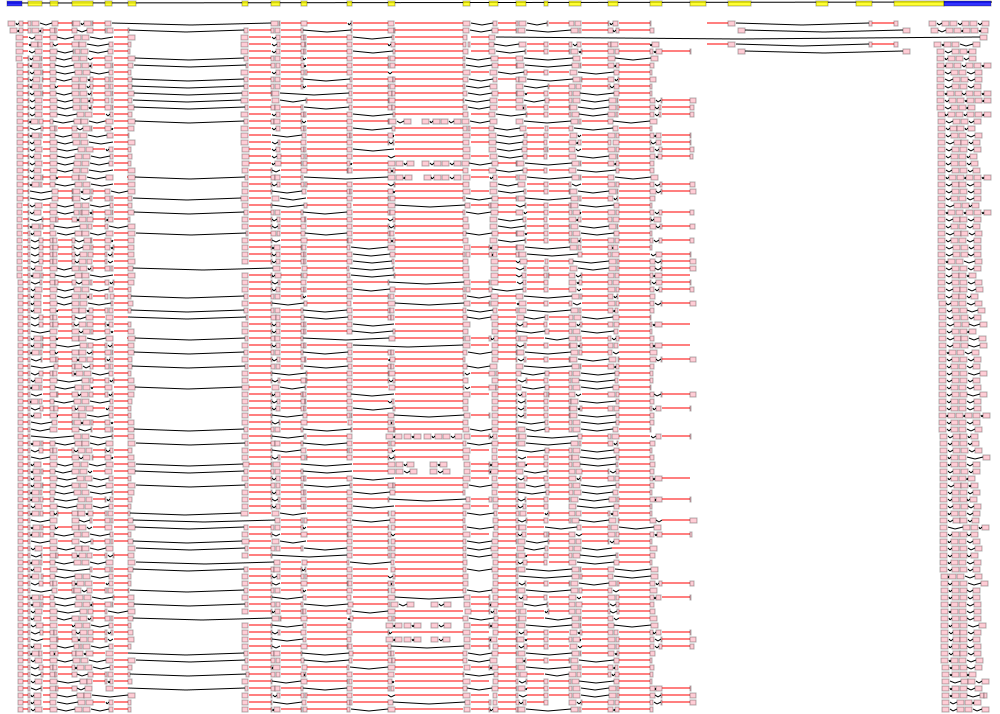

In [324]:
from IPython.display import SVG, display
display(SVG('./test.svg'))

In [304]:
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
PAIRID,,,,,,,,,,,,,,,,,,,,,
2,SRR2132433.39155300.2,161,chromosome_1,23732,50,100M,=,23917,285,CAGGCAGAGGACACGGGCGCTAGAGGTGGCTCTGGGCTAGTGCGGC...,...,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:0A99,YT:Z:UU,NH:i:1,NaN,NaN,NaN
1,SRR2132433.39155300.1,81,chromosome_1,23917,50,100M,=,23732,-285,CTCCTGGCATGACATTGGCAAGCTTTTTGGATTCCACGAGGTGCAA...,...,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:100,YT:Z:UU,NH:i:1,NaN,NaN,NaN


In [185]:
df_sam_index.loc[('SRR2132433','18073440')]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
PAIRID,,,,,,,,,,,,,,,,,,,
1,SRR2132433.18073440.1,83,chromosome_1,18665,50,12M652N88M,=,18579,-838,TTGATTCGGCAGGTGGTTATCATGGAGTCAGTGCGGAAGACGGTCA...,:C@?DDBDDCDDDC@CADCCCDCCCDDDCBBDDBDDDDDDDDECDE...,AS:i:-13,XM:i:1,XO:i:0,XG:i:0,MD:Z:99T0,NM:i:1,XS:A:+,NH:i:1
